In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import re
from collections import Counter
from wordcloud import WordCloud
from tokenizers import Tokenizer
from huggingface_hub import HfApi

/Users/rutvikdhopate/Downloads/Jupyter_Files/Clinical-Trials-Eligibility/nlp_project_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('../Dataset/cleaned_data_3.csv')
tokenizer = Tokenizer.from_file('../BPE/bpe_tokenizer.json')

In [40]:
tokenizer.token_to_id("intracanal")

4463

In [5]:
tokenizer.encode("pharyngities")

Encoding(num_tokens=2, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
df.head()

,patient,criteria,label
0,a 45 year old male was found unresponsive afte...,inclusion criteria age greater than or equal t...,1.0
1,a 62 year old female suffered an out of hospit...,inclusion criteria age greater than or equal t...,1.0
2,an 18 year old male experienced an out of hosp...,inclusion criteria age greater than or equal t...,1.0
3,a 70 year old female suffered an out of hospit...,inclusion criteria age greater than or equal t...,1.0
4,a 50 year old male was brought to the ed after...,inclusion criteria age greater than or equal t...,1.0


In [3]:
df['patient'].apply(lambda x: len(x.split())).mean()

np.float64(186.4540174249758)

In [4]:
df['combined'] = "[CLS] " + df['patient'] + " [SEP] " + df['criteria']
df['combined'].apply(lambda x: len(tokenizer.encode(x).tokens)).max(), df['combined'].apply(lambda x: len(tokenizer.encode(x).tokens)).min(), df['combined'].apply(lambda x: len(tokenizer.encode(x).tokens)).mean()

(np.int64(1383), np.int64(80), np.float64(277.6669893514037))

In [29]:
from datetime import datetime

In [32]:
datetime.now().strftime("%d%m%y_%H%M%S")

'010825_155124'

In [ ]:
hf = HfApi()

In [ ]:
# hf.create_repo(repo_id="rdhopate/nlp-clinical-trials", repo_type="model", exist_ok=True)

RepoUrl('https://huggingface.co/rdhopate/nlp-clinical-trials', endpoint='https://huggingface.co', repo_type='model', repo_id='rdhopate/nlp-clinical-trials')

In [42]:
# hf.upload_file(path_or_fileobj="EDA.ipynb", path_in_repo="EDA.ipynb", repo_id="rdhopate/nlp-clinical-trials", repo_type="model")

Text(0, 0.5, 'Frequency')

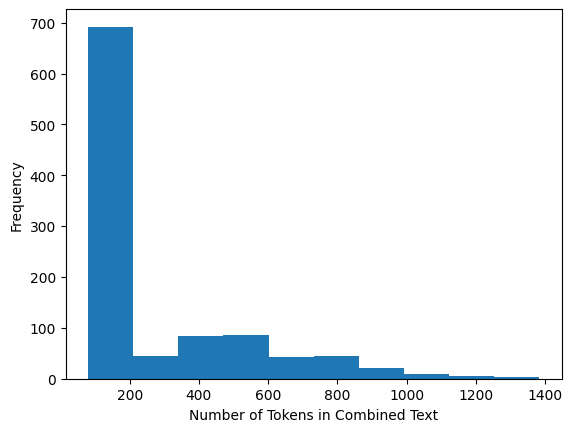

In [5]:
combined_token_len = df['combined'].apply(lambda x: len(tokenizer.encode(x).tokens))
plt.hist(combined_token_len)
plt.xlabel('Number of Tokens in Combined Text')
plt.ylabel('Frequency')

In [6]:
combined_token_len = df['combined'].apply(lambda x: len(tokenizer.encode(x).tokens))

# Compute statistics
max_tokens = combined_token_len.max()
min_tokens = combined_token_len.min()
mean_tokens = combined_token_len.mean()

percentile_1024 = (combined_token_len <= 1024).mean() * 100  # percentage of samples ≤ 1024

counts, bins = np.histogram(combined_token_len, bins=20)
max_count = counts.max()

fig = px.histogram(
    x=combined_token_len,
    nbins=20,
    title="Token Distribution",
    labels={"x": "Number of Tokens in Input Text", "y": "Frequency"},
    color_discrete_sequence=["royalblue"]
)

stats_text = (
    f"Max: {max_tokens}<br>"
    f"Min: {min_tokens}<br>"
    f"Mean: {mean_tokens:.2f}<br>"
    f"1024th Percentile: {percentile_1024:.2f}%"
)

fig.add_annotation(
    x=max_tokens,
    y=max_count * 0.8,
    text=stats_text,
    showarrow=False,
    align="left",
    bgcolor="white",
    bordercolor="black",
    borderwidth=1,
    font=dict(size=14)
)

fig.add_vline(
    x=1024,
    line_width=2,
    line_dash="dash",
    line_color="red",
    annotation_text=f"1024 tokens ({percentile_1024:.1f}th percentile)",
    annotation_position="top"
)

fig.show()

In [12]:
# label_distribution = df['label'].apply(lambda x: len(tokenizer.encode(x).tokens))

label_counts = df['label'].value_counts(normalize=False)  
label_percent = df['label'].value_counts(normalize=True) * 100

data = pd.DataFrame({
    "label": label_counts.index,
    "count": label_counts.values,
    "percentage": label_percent.values.round(2)
})

fig = px.bar(
    data,
    x="label",
    y="count",
    text="percentage",  
    title="Label Distribution",
    labels={"label": "Label", "count": "Number of Examples"},
    color_discrete_sequence=["orange"]
)

fig.update_traces(
    texttemplate='%{text} %',  
    textposition='outside',   
    width=0.2                 
)

fig.update_layout(
    uniformtext_minsize=10,
    uniformtext_mode='hide',
    yaxis_title="Frequency",
    xaxis_title="Labels",
)

fig.show()

In [9]:
import plotly.graph_objects as go

table_df = df.iloc[:,:-1].head(3)

fig = go.Figure(
    data=[go.Table(
        header=dict(values=list(table_df.columns),
                    fill_color='royalblue',
                    font=dict(color='white', size=14),
                    align='center'),
        cells=dict(values=[table_df[col] for col in table_df.columns],
                   fill_color='white',
                   align='center')
    )]
)

fig.update_layout(title="Preprocessed Data Sample")
fig.show()

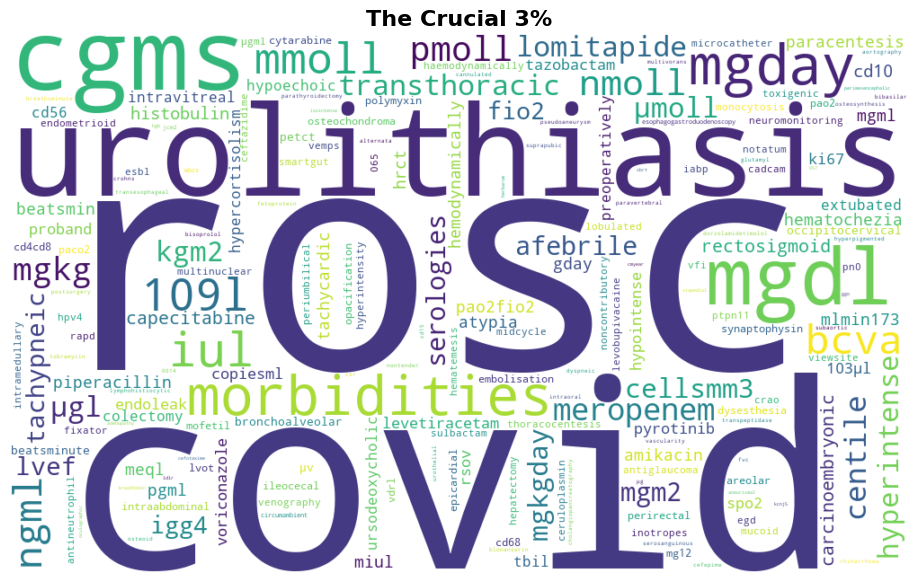

In [10]:
# Unknown words wordcloud

glove_path = '/Applications/Northeastern MS DS/USML Virgil Pavlu/USML Assignment Data/archive-2/glove.6B.100d.txt'
glove_vocab = set()
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        word = line.split()[0]
        glove_vocab.add(word)

all_text = " ".join(df['combined'].astype(str).tolist())
tokens = re.findall(r"\b\w+\b", all_text.lower())

tokens_not_in_glove = [t for t in tokens if t not in glove_vocab]
freq_not_in_glove = Counter(tokens_not_in_glove)

percent_missing = (len(tokens_not_in_glove) / len(tokens)) * 100

wordcloud = WordCloud(
    width=1000,
    height=600,
    background_color="white",
    colormap="viridis"
).generate_from_frequencies(freq_not_in_glove)

plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title(
    f"The Crucial 3%",
    fontsize=16,
    fontweight="bold"
)
plt.show()

In [ ]:
n = 350
d = (n+400+283)
n/d, 400/d, 283/d


(0.3388189738625363, 0.3872216844143272, 0.2739593417231365)